<center><img src="https://raw.githubusercontent.com/dimitreOliveira/MachineLearning/master/Kaggle/Understanding%20Clouds%20from%20Satellite%20Images/banner.png" width="800"></center>

<h1><center>Understanding Clouds from Satellite Images</center></h1>
<h2><center>Can you classify cloud structures from satellites?</center></h2>

#### In this competition we need to analyze and process cloud images taken from satellites in order to identify cloud formations and help improve the earth's climate understanding.

### Dependencies

In [1]:
import os
import cv2
import keras
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import set_random_seed
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras import backend as K
from keras.models import Model
from keras.losses import binary_crossentropy
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate

def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    set_random_seed(seed)

seed = 0
seed_everything(seed)
%matplotlib inline
warnings.filterwarnings("ignore")

!pip install segmentation-models
import segmentation_models as sm

Using TensorFlow backend.
/home/harrison/anaconda3/envs/kaggle/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/harrison/anaconda3/envs/kaggle/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/harrison/anaconda3/envs/kaggle/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/harrison

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


### Load data

In [2]:
train = pd.read_csv('../input/understanding_cloud_organization/train.csv')
submission = pd.read_csv('../input/understanding_cloud_organization/sample_submission.csv')
print('Number of train samples:', train.shape[0])
print('Number of test samples:', submission.shape[0])

# Preprocecss data
train['image'] = train['Image_Label'].apply(lambda x: x.split('_')[0])
train['label'] = train['Image_Label'].apply(lambda x: x.split('_')[1])
submission['image'] = submission['Image_Label'].apply(lambda x: x.split('_')[0])
test = pd.DataFrame(submission['image'].unique(), columns=['image'])

display(train.head())
display(train.describe())

FileNotFoundError: [Errno 2] File b'../input/understanding_cloud_organization/train.csv' does not exist: b'../input/understanding_cloud_organization/train.csv'

# EDA

### We have four possible label classes(Fish, Flower, Gravel, Sugar), now let's look at some samples from the training set


#### Without mask

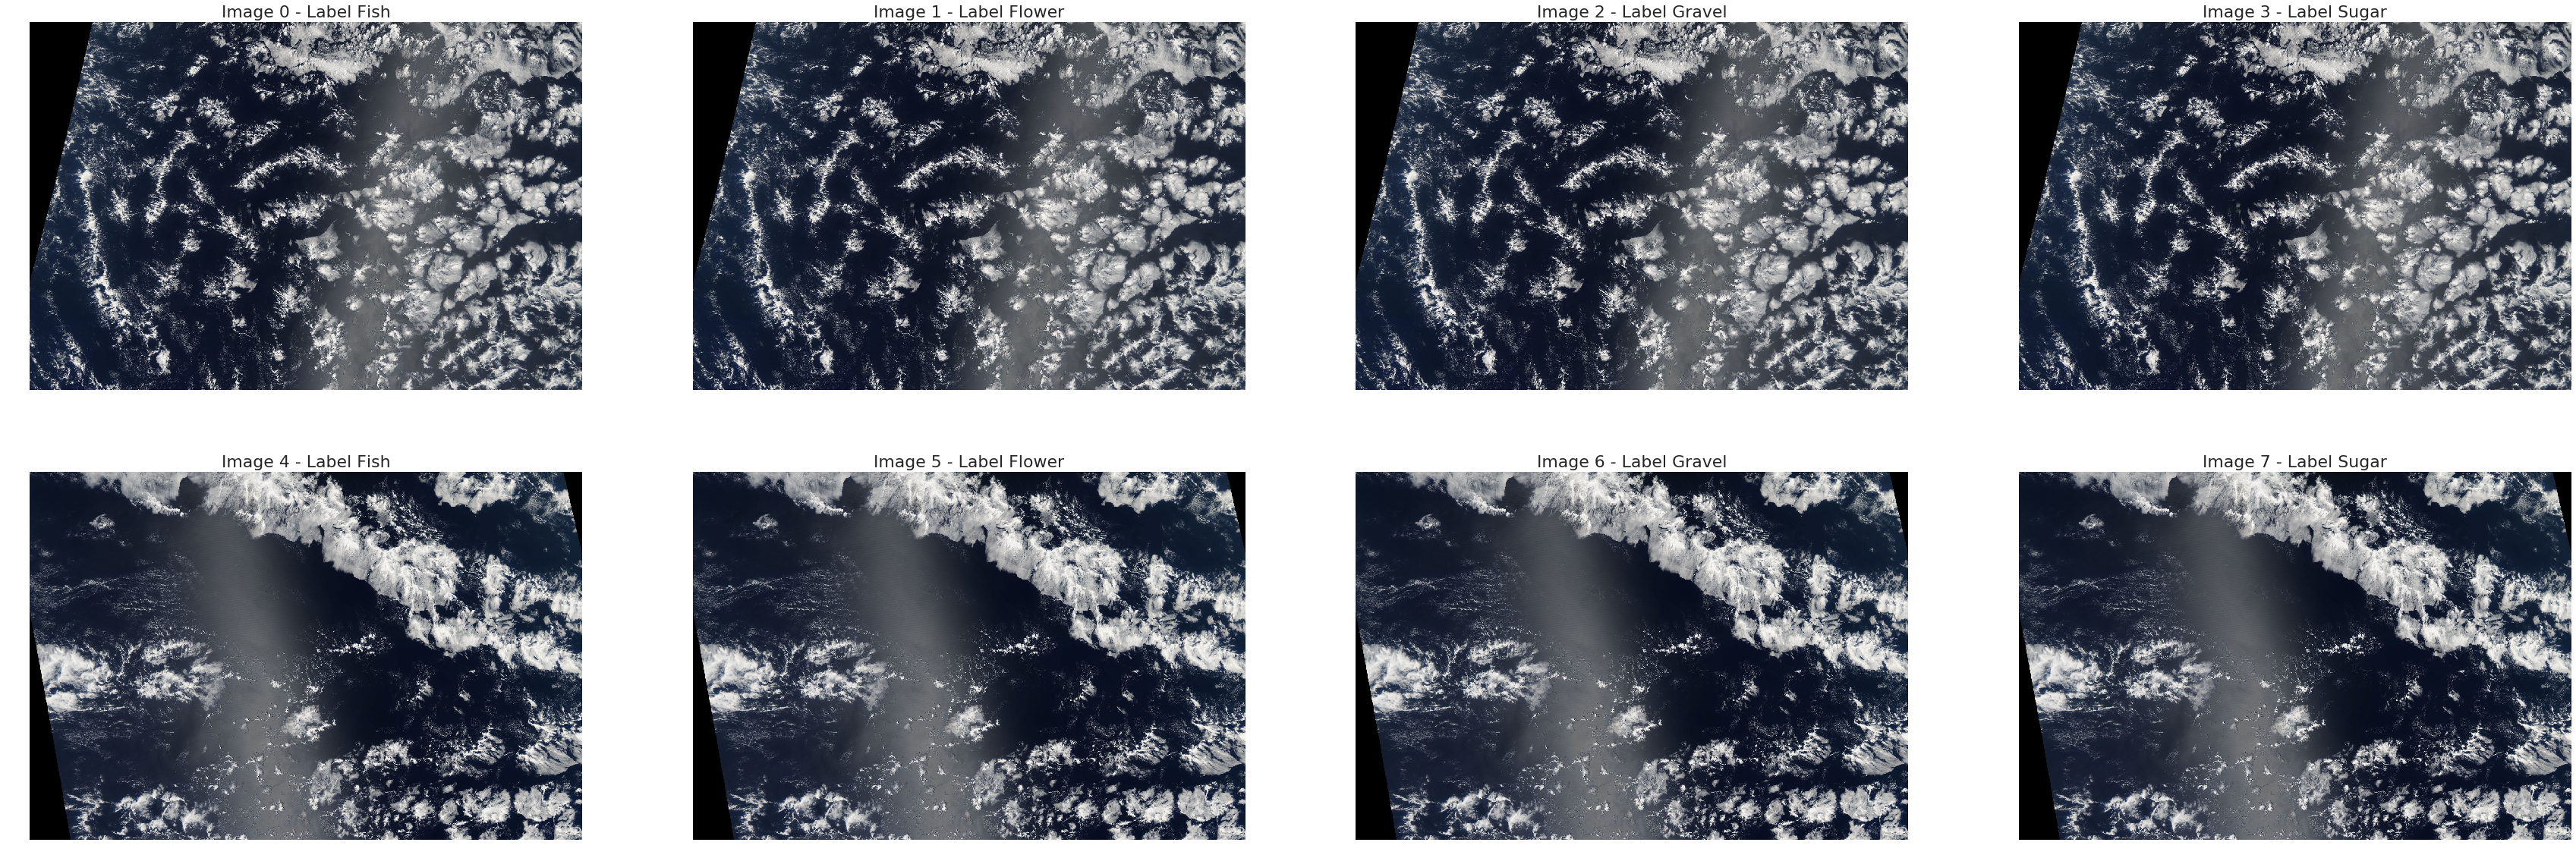

In [3]:
sns.set_style("white")
plt.figure(figsize=[60, 20])
for index, row in train[:8].iterrows():
    img = cv2.imread("../input/understanding_cloud_organization/train_images/%s" % row['image'])[...,[2, 1, 0]]
    plt.subplot(2, 4, index+1)
    plt.imshow(img)
    plt.title("Image %s - Label %s" % (index, row['label']), fontsize=22)
    plt.axis('off')    
    
plt.show()

#### With mask

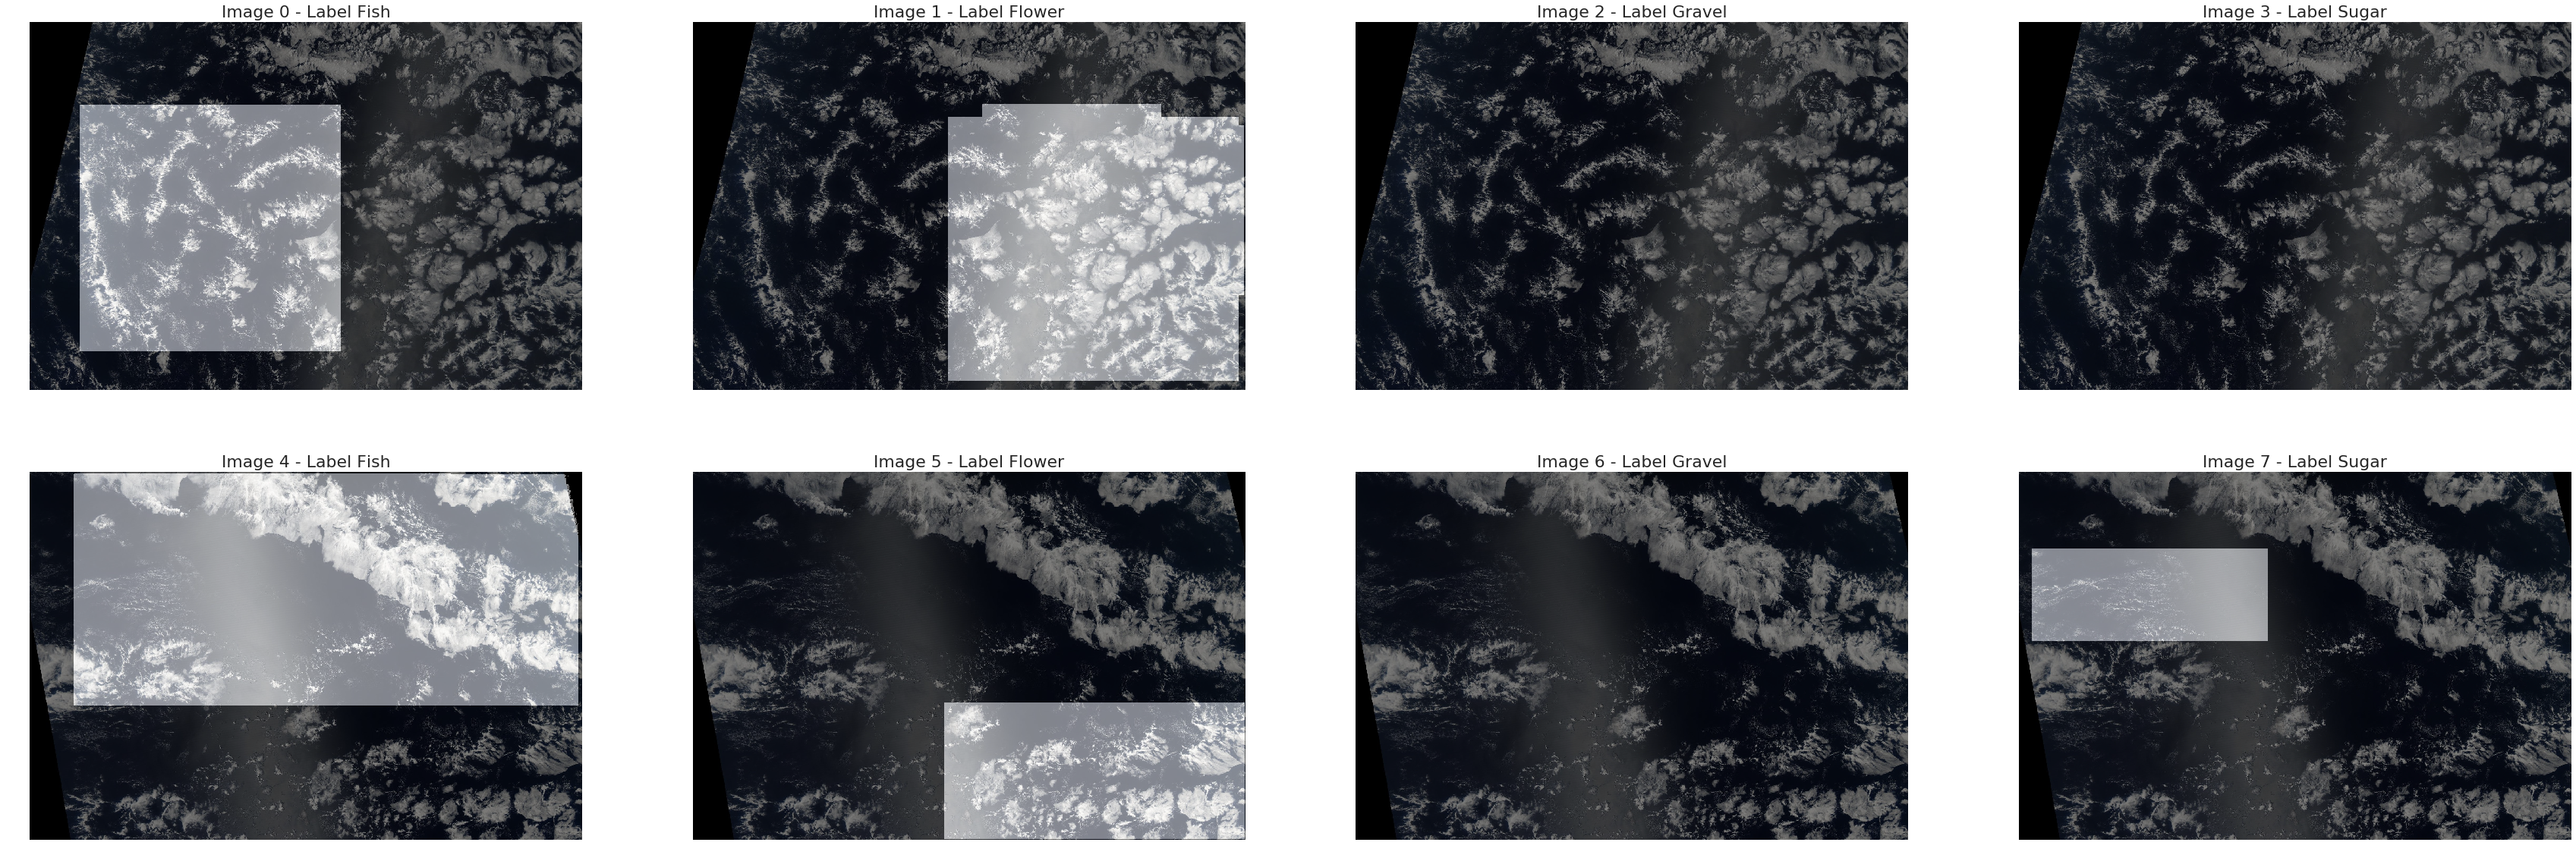

In [4]:
def rle_decode(mask_rle, shape=(1400, 2100)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')  # Needed to align to RLE direction

plt.figure(figsize=[60, 20])
for index, row in train[:8].iterrows():
    img = cv2.imread("../input/understanding_cloud_organization/train_images/%s" % row['image'])[...,[2, 1, 0]]
    mask_rle = row['EncodedPixels']
    try: # label might not be there!
        mask = rle_decode(mask_rle)
    except:
        mask = np.zeros((1400, 2100))
    plt.subplot(2, 4, index+1)
    plt.imshow(img)
    plt.imshow(mask, alpha=0.5, cmap='gray')
    plt.title("Image %s - Label %s" % (index, row['label']), fontsize=22)
    plt.axis('off')    
    
plt.show()

Looking at these samples some images seem to have a light reflection, maybe we can remove them during preprocess, or even add this reflection to other images for some image augmentation.

Also, some have a black area, from the competition description the reason is this: "Due to the small footprint of the imager (MODIS) on board these satellites, an image might be stitched together from two orbits. The remaining area, which has not been covered by two succeeding orbits, is marked black."

## Number of samples for each label (cloud formation)

 As we can see the dataset if perfectly balanced, at least looking at the label count, we have 5546 samples for each of the 4 cloud formation types.

Fish 5546
Flower 5546
Gravel 5546
Sugar 5546


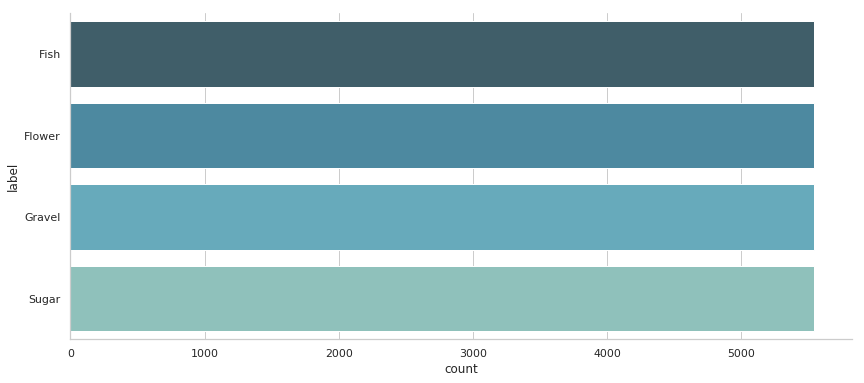

In [5]:
for lbl in train['label'].unique():
    print('%s %s' % (lbl, len(train[train['label'] == lbl])))

sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(14, 6))
ax = sns.countplot(y="label", data=train, palette="GnBu_d")
sns.despine()
plt.show()

### Let's take a look at a sample from each class

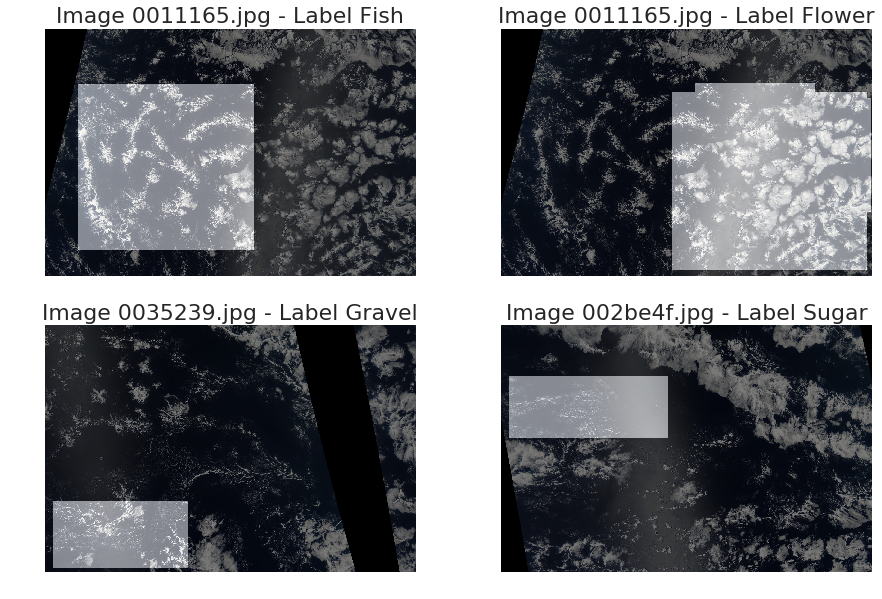

In [6]:
train['Has Mask'] = ~train['EncodedPixels'].isna()
maskedSamples = train[train['Has Mask'] == True]
firstLabel = maskedSamples.groupby('label').first().reset_index()

sns.set_style("white")
plt.figure(figsize=[15, 10])
for index, row in firstLabel.iterrows():
    img = cv2.imread("../input/understanding_cloud_organization/train_images/%s" % row['image'])[...,[2, 1, 0]]
    plt.subplot(2, 2, index+1)
    mask_rle = row['EncodedPixels']
    try: # label might not be there!
        mask = rle_decode(mask_rle)
    except:
        mask = np.zeros((1400, 2100))
    plt.imshow(img)
    plt.imshow(mask, alpha=0.5, cmap='gray')
    plt.title("Image %s - Label %s" % (row['image'], row['label']), fontsize=22)
    plt.axis('off')

plt.show()

## Segmented area distribution

### Some of the samples don't have a segmentation mask, this means that the image doesn't have any of the label's cloud formation

Almost half of the samples don't have a mask, images that don't have any of the four cloud formations should not have a prediction on the output file.

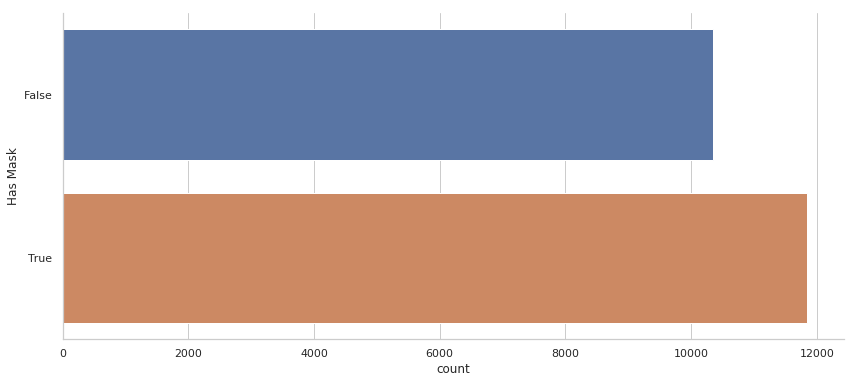

In [7]:
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(14, 6))
ax = sns.countplot(y="Has Mask", data=train)
sns.despine()
plt.show()

## Number of mask per sample

#### Each image can have more than one label, and labels from different classes.

So on the dataset each image will have four rows and will only have "EncodedPixels" feature if it has that label, look at the image "0011165.jpg" it has "Fish" and  "Flower" cloud formations, so it has values for those labels, and the other are null

In [8]:
display(train[train['image'] == '0011165.jpg'])

Image_Label                                      EncodedPixels  \
0    0011165.jpg_Fish  264918 937 266318 937 267718 937 269118 937 27...   
1  0011165.jpg_Flower  1355565 1002 1356965 1002 1358365 1002 1359765...   
2  0011165.jpg_Gravel                                                NaN   
3   0011165.jpg_Sugar                                                NaN   

         image   label  Has Mask  
0  0011165.jpg    Fish      True  
1  0011165.jpg  Flower      True  
2  0011165.jpg  Gravel     False  
3  0011165.jpg   Sugar     False

### Most of the images have at least 2 labels, and only a few have all the 4 cloud formations.

Samples with 1 masks: 1348
Samples with 2 masks: 2372
Samples with 3 masks: 1560
Samples with 4 masks: 266


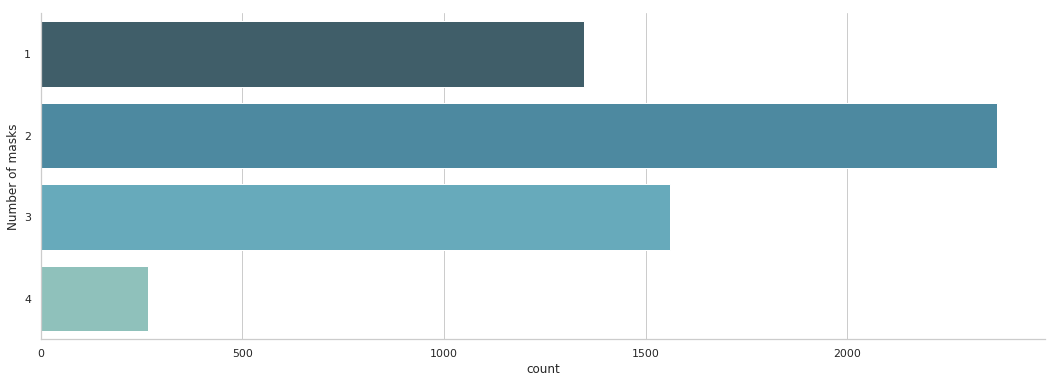

In [9]:
maskedSamples_gp = maskedSamples.groupby('image').size().reset_index(name='Number of masks')

for n_masks in np.sort(maskedSamples_gp['Number of masks'].unique()):
    print('Samples with %s masks: %s' % (n_masks, len(maskedSamples_gp[maskedSamples_gp['Number of masks'] == n_masks])))
    
f, ax = plt.subplots(figsize=(18, 6))
ax = sns.countplot(y="Number of masks", data=maskedSamples_gp, palette="GnBu_d")
sns.despine()
plt.show()

## Split train and validation sets

In [10]:
mask_count_df = train.groupby('image').agg(np.sum).reset_index()
mask_count_df.sort_values('Has Mask', ascending=False, inplace=True)
train_idx, val_idx = train_test_split(mask_count_df.index, test_size=0.2, random_state=seed)

In [11]:
def np_resize(img, input_shape):
    height, width = input_shape
    return cv2.resize(img, (width, height))
    
def mask2rle(img):
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(rle, input_shape):
    width, height = input_shape[:2]
    
    mask = np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return mask.reshape(height, width).T

def build_masks(rles, input_shape, reshape=None):
    depth = len(rles)
    if reshape is None:
        masks = np.zeros((*input_shape, depth))
    else:
        masks = np.zeros((*reshape, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            if reshape is None:
                masks[:, :, i] = rle2mask(rle, input_shape)
            else:
                mask = rle2mask(rle, input_shape)
                reshaped_mask = np_resize(mask, reshape)
                masks[:, :, i] = reshaped_mask
    
    return masks

def build_rles(masks, reshape=None):
    width, height, depth = masks.shape
    rles = []
    
    for i in range(depth):
        mask = masks[:, :, i]
        
        if reshape:
            mask = mask.astype(np.float32)
            mask = np_resize(mask, reshape).astype(np.int64)
        
        rle = mask2rle(mask)
        rles.append(rle)
        
    return rles

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred) 

# Model parameters

In [12]:
BATCH_SIZE = 16
EPOCHS = 15
LEARNING_RATE = 3e-4
HEIGHT = 320
WIDTH = 480
CHANNELS = 3
N_CLASSES = train['label'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5
BACKBONE = 'resnet34'

## Data generator

#### I got the data generators and predictions from @xhlulu kernel: [Satellite Clouds: Yet another U-Net boilerplate](https://www.kaggle.com/xhlulu/satellite-clouds-yet-another-u-net-boilerplate/notebook) check out, I just changed a few things to make the code more familiar to me.

In [13]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, df, target_df=None, mode='fit',
                 base_path='../input/understanding_cloud_organization/train_images',
                 batch_size=BATCH_SIZE, dim=(1400, 2100), n_channels=CHANNELS, reshape=None, 
                 n_classes=N_CLASSES, random_state=seed, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.reshape = reshape
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state
        
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)
            
            return X, y
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        'Generates data containing batch_size samples'
        # Initialization
        if self.reshape is None:
            X = np.empty((self.batch_size, *self.dim, self.n_channels))
        else:
            X = np.empty((self.batch_size, *self.reshape, self.n_channels))
        
        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['image'].iloc[ID]
            img_path = f"{self.base_path}/{im_name}"
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32) / 255.
#             img = preprocess_input(img)
            
            if self.reshape is not None:
                img = np_resize(img, self.reshape)
            
            # Store samples
            X[i,] = img

        return X
    
    def __generate_y(self, list_IDs_batch):
        if self.reshape is None:
            y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)
        else:
            y = np.empty((self.batch_size, *self.reshape, self.n_classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['image'].iloc[ID]
            image_df = self.target_df[self.target_df['image'] == im_name]
            
            rles = image_df['EncodedPixels'].values
            
            if self.reshape is not None:
                masks = build_masks(rles, input_shape=self.dim, reshape=self.reshape)
            else:
                masks = build_masks(rles, input_shape=self.dim)
            
            y[i, ] = masks

        return y
    
train_generator = DataGenerator(
                  train_idx, 
                  df=mask_count_df,
                  target_df=train,
                  batch_size=BATCH_SIZE,
                  reshape=(HEIGHT, WIDTH),
                  n_channels=CHANNELS,
                  n_classes=N_CLASSES,
                  random_state=seed)

valid_generator = DataGenerator(
                  val_idx, 
                  df=mask_count_df,
                  target_df=train,
                  batch_size=BATCH_SIZE, 
                  reshape=(HEIGHT, WIDTH),
                  n_channels=CHANNELS,
                  n_classes=N_CLASSES,
                  random_state=seed)

# Model

#### You can find the explaination about the loss function on [this great post](https://lars76.github.io/neural-networks/object-detection/losses-for-segmentation/).

In [14]:
preprocess_input = sm.backbones.get_preprocessing(BACKBONE)

model = sm.Unet(
           encoder_name=BACKBONE, 
           classes=N_CLASSES,
           activation='sigmoid',
           input_shape=(HEIGHT, WIDTH, CHANNELS))


es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

metric_list = [dice_coef]
callback_list = [es, rlrop]
optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=metric_list)
model.summary()

58892288/58889256 [==============================] - 5s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 480, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 320, 480, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 320, 480, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 160, 240, 64) 0           block1_conv2[0][0]               
____________________________________________

In [15]:
history = model.fit_generator(generator=train_generator,
                              validation_data=valid_generator,
                              epochs=EPOCHS,
                              callbacks=callback_list,
                              verbose=2).history

Epoch 1/15
 - 568s - loss: 1.0648 - dice_coef: 0.3508 - val_loss: 1.1517 - val_dice_coef: 0.3102
Epoch 2/15
 - 537s - loss: 0.9038 - dice_coef: 0.4360 - val_loss: 0.9274 - val_dice_coef: 0.4489
Epoch 3/15
 - 526s - loss: 0.8565 - dice_coef: 0.4725 - val_loss: 1.3986 - val_dice_coef: 0.3904
Epoch 4/15
 - 538s - loss: 0.8302 - dice_coef: 0.4919 - val_loss: 1.0121 - val_dice_coef: 0.4395
Epoch 5/15
 - 531s - loss: 0.8138 - dice_coef: 0.5040 - val_loss: 0.8378 - val_dice_coef: 0.5050
Epoch 6/15
 - 510s - loss: 0.7997 - dice_coef: 0.5135 - val_loss: 0.8717 - val_dice_coef: 0.4905
Epoch 7/15
 - 521s - loss: 0.7847 - dice_coef: 0.5229 - val_loss: 0.8698 - val_dice_coef: 0.4885
Epoch 8/15
 - 507s - loss: 0.7719 - dice_coef: 0.5315 - val_loss: 0.8513 - val_dice_coef: 0.4902

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
Epoch 9/15
 - 504s - loss: 0.7333 - dice_coef: 0.5560 - val_loss: 0.8078 - val_dice_coef: 0.5147
Epoch 10/15
 - 521s - loss: 0.7070 - dice_coef

## Model loss graph

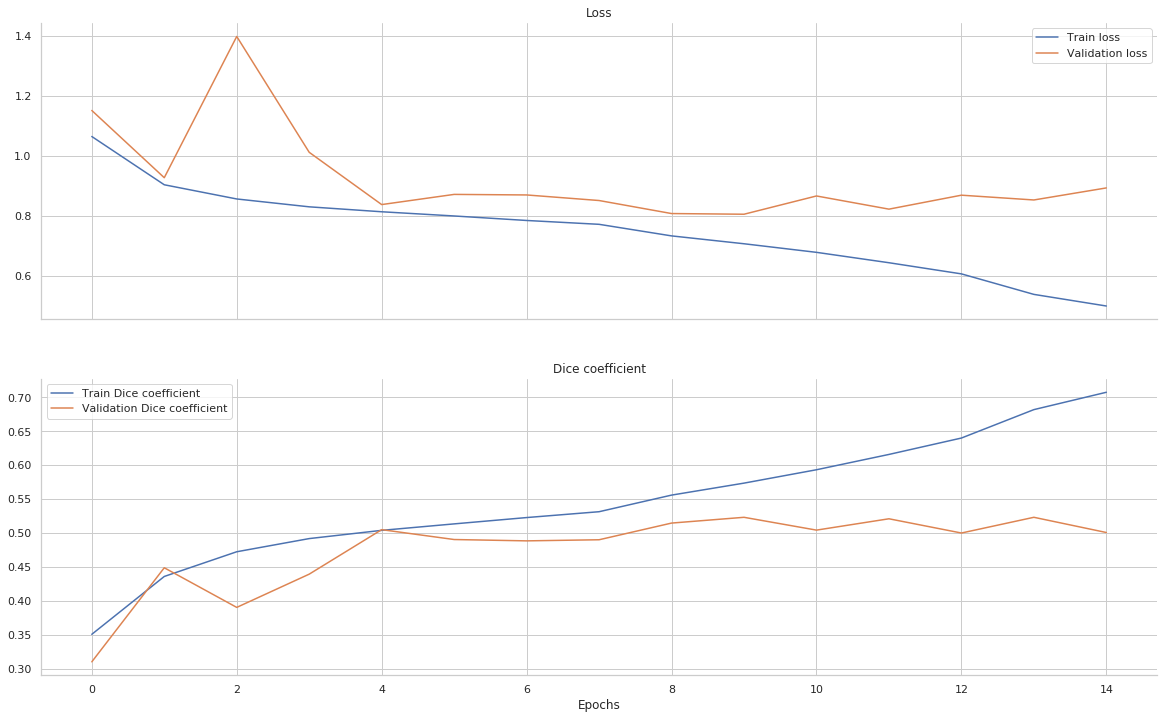

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 12))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['dice_coef'], label='Train Dice coefficient')
ax2.plot(history['val_dice_coef'], label='Validation Dice coefficient')
ax2.legend(loc='best')
ax2.set_title('Dice coefficient')

plt.xlabel('Epochs')
sns.despine()
plt.show()

# Apply model to test set

In [17]:
test_df = []

for i in range(0, test.shape[0], 500):
    batch_idx = list(range(i, min(test.shape[0], i + 500)))
    
    test_generator = DataGenerator(
                     batch_idx,
                     df=test,
                     target_df=submission,
                     batch_size=1,
                     reshape=(HEIGHT, WIDTH),
                     dim=(350, 525),
                     n_channels=CHANNELS,
                     n_classes=N_CLASSES,
                     random_state=seed,
                     base_path='../input/understanding_cloud_organization/test_images',
                     mode='predict',
                     shuffle=False)
    
    batch_pred_masks = model.predict_generator(
                             test_generator, 
                             verbose=2)
    
    for j, b in enumerate(batch_idx):
        filename = test['image'].iloc[b]
        image_df = submission[submission['image'] == filename].copy()
        
        pred_masks = batch_pred_masks[j, ].round().astype(int)
        pred_rles = build_rles(pred_masks, reshape=(350, 525))
        
        image_df['EncodedPixels'] = pred_rles
        test_df.append(image_df)
        
sub_df = pd.concat(test_df)

# Inspecting some of the predictions

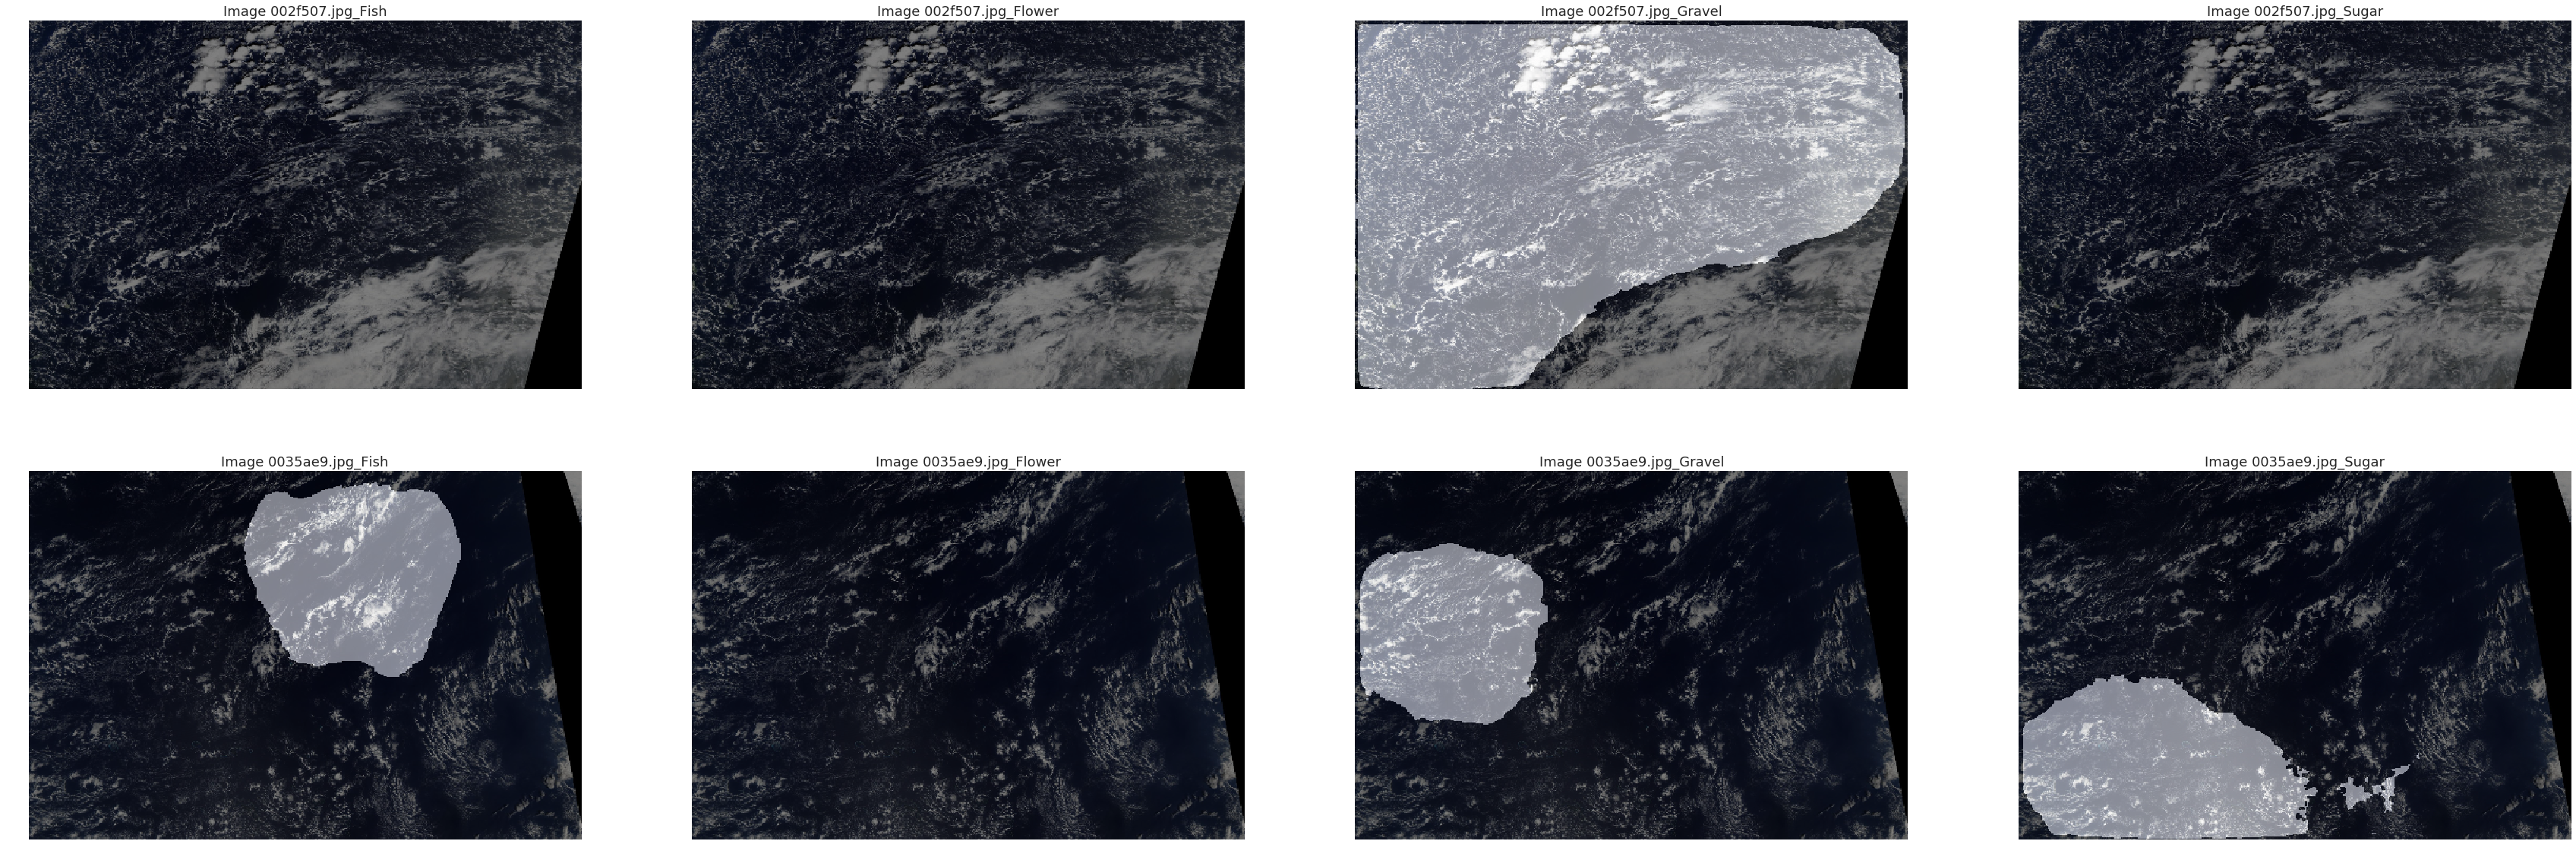

In [18]:
sns.set_style("white")
plt.figure(figsize=[60, 20])
for index, row in sub_df[:8].iterrows():
    img = cv2.imread("../input/understanding_cloud_organization/test_images/%s" % row['image'])[...,[2, 1, 0]]
    img = cv2.resize(img, (525, 350))
    mask_rle = row['EncodedPixels']
    try: # label might not be there!
        mask = rle_decode(mask_rle)
    except:
        mask = np.zeros((1400, 2100))
    plt.subplot(2, 4, index+1)
    plt.imshow(img)
    plt.imshow(rle2mask(mask_rle, img.shape), alpha=0.5, cmap='gray')
    plt.title("Image %s" % (row['Image_Label']), fontsize=18)
    plt.axis('off')    
    
plt.show()

## Without background

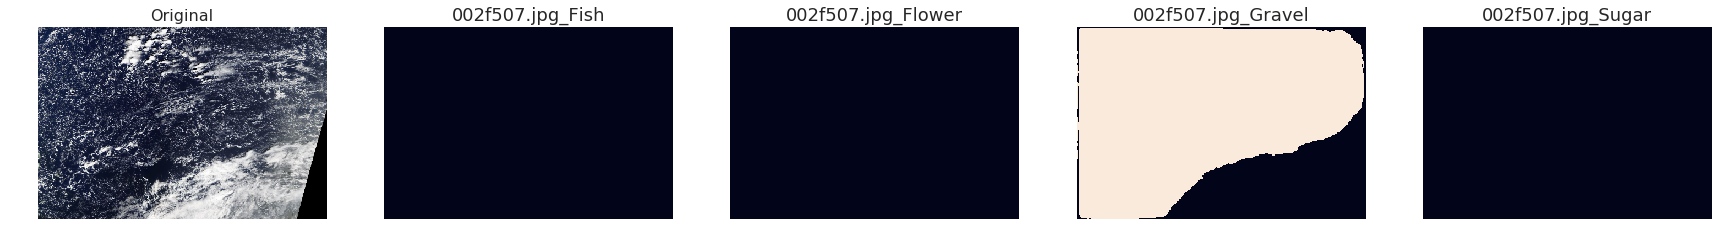

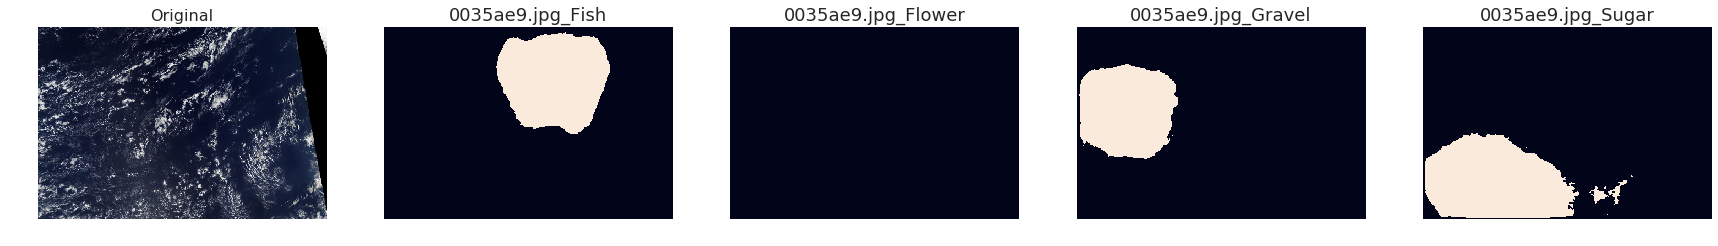

In [19]:
fig, axs = plt.subplots(1, 5, figsize=(30, 30))
axs[0].imshow(cv2.resize(plt.imread('../input/understanding_cloud_organization/test_images/%s' % sub_df['image'][0]),(525, 350)))
axs[0].set_title('Original', fontsize=16)
axs[0].axis('off')
for i in range(4):
    axs[i+1].imshow(rle2mask(sub_df['EncodedPixels'][i], img.shape))
    axs[i+1].set_title(sub_df['Image_Label'][i], fontsize=18)
    axs[i+1].axis('off')
    
fig, axs = plt.subplots(1, 5, figsize=(30, 30))
axs[0].imshow(cv2.resize(plt.imread('../input/understanding_cloud_organization/test_images/%s' % sub_df['image'][4]),(525, 350)))
axs[0].set_title('Original', fontsize=16)
axs[0].axis('off')
for i in range(4):
    axs[i+1].imshow(rle2mask(sub_df['EncodedPixels'][4 + i], img.shape))
    axs[i+1].set_title(sub_df['Image_Label'][4 + i], fontsize=18)
    axs[i+1].axis('off')

In [20]:
sub_df = sub_df[['Image_Label', 'EncodedPixels']]
sub_df.to_csv('submission.csv', index=False)
display(sub_df.head(10))

Image_Label                                      EncodedPixels
0    002f507.jpg_Fish                                                   
1  002f507.jpg_Flower                                                   
2  002f507.jpg_Gravel  45 5 60 7 70 21 102 49 165 43 213 4 225 16 431...
3   002f507.jpg_Sugar                                                   
4    0035ae9.jpg_Fish  71472 4 71815 12 71830 5 71839 1 72163 28 7250...
5  0035ae9.jpg_Flower                                                   
6  0035ae9.jpg_Gravel  1523 4 1857 66 1931 15 2205 70 2278 24 2550 10...
7   0035ae9.jpg_Sugar  1644 53 1699 4 1993 63 2339 68 2689 68 3039 72...
8    0038327.jpg_Fish                                                   
9  0038327.jpg_Flower  138888 9 139238 9 139590 9 139621 1 139625 2 1...